# 机器学习 实验3

**基于全链接网络的手写数字体识别**

- 数据：MNIST data set
- 本题目考察如何设计并实现一个简单的图像分类器，设置本题目的目的如下：
1. 理解基本的图像识别流程的方法（预处理、训练、预测等阶段）
2. 实现一个全连接神经网络分类器
3. 理解不同的分类器之间的区别，以及使用不同的更新方法优化神经网络

- 课后作业：
1. 完成测试集上的测试过程

- 附加题： 
1. 尝试使用不同的损失函数和正则化方法，观察并分析其对实验结果的影响 
2. 尝试使用不同的优化算法，观察并分析其对训练过程和实验结果的影响， (如batch GD, online GD, mini-batch GD, SGD, 或其它的优化算法，如Momentum, Adsgrad, Adam, Admax)
3. 增加训练的epoch，并绘制loss变化的图像
4. 更改网络的结构，查看对训练过程额和最终结果有何影响

- 补充：MINST是一个手写数字数据集，包括了若干手写数字体及其对应的数字，共60000个训练样本，10000个测试样本。每个手写数字被表示为一个28*28的向量。  

## 1 准备数据+数据预处理

In [270]:
import torch
from torchvision import transforms
from torchvision.datasets import mnist  # 导入内置的 mnist 数据

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

transform = transforms.Compose([
    transforms.ToTensor(),   # 将图像转换为PyTorch的张量（tensor）格式，这是神经网络模型所需的数据格式
    transforms.Normalize([0.5], [0.5])   # 如果不缩放，像素值范围较大可能会导致梯度爆炸或梯度消失等问题，从而影响模型的训练效果
])

# 使用mnist.MNIST()函数创建训练集、测试集两个数据集对象
train_set = mnist.MNIST('./data copy', train=True, transform=transform, download=True)
test_set = mnist.MNIST('./data copy', train=False, transform=transform, download=True)

cuda


### 1.1 了解数据

In [271]:
a_data, a_label = train_set[0]
a_data.shape

torch.Size([1, 28, 28])

### 1.2 创建数据加载器（DataLoader）对象

用于在训练和测试神经网络模型时加载数据

In [272]:
from torch.utils.data import*

train_data = DataLoader(train_set, batch_size=64,shuffle=True)
test_data = DataLoader(test_set, batch_size=128,shuffle=False)


## 2 neural network structure

In [273]:
from torch import nn

class FNN(nn.Module):
    def __init__(self):
        super(FNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784,400),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(400,200),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200,100),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(100,10))

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        output = self.layer4(x)
        return output

## 3 训练网络model

In [274]:
net = FNN().to(device)
net.parameters

<bound method Module.parameters of FNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)>

In [275]:
def train_model(net, train_data, test_data, loss_func, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        train_loss = 0
        correct = 0
        total = 0

        # Training process
        for image, label in train_data:
            image = image.to(device)
            label = label.to(device)
            image = image.view(image.size(0), -1)

            out = net(image)
            loss = loss_func(out, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        avg_loss = train_loss / len(train_data)
        train_accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)

        print(f'epoch:{epoch + 1}, Train loss：{avg_loss:.6f}, Train Accuracy: {train_accuracy:.6f}')

    # Testing process
    net.eval() 	# 将模型改为预测模式,不启用 BatchNormalization 和 Dropout
    correct = 0
    total = 0
    for image, label in test_data:
        image = image.to(device)
        label = label.to(device)
        image = image.view(image.size(0), -1)

        out = net(image)
        loss = loss_func(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.6f}')

    return train_losses, train_accuracies, test_accuracy

In [276]:
import torch
loss_cross = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=1e-3,lr=1e-3)


In [277]:
# losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)


## 4 尝试不同正则化、优化方法，并分析结果

- 使用SGD随机梯度下降算法，尝试不同的L2正则化的参数lambda
- 使用adam优化算法，正则化参数

In [278]:
# 使用交叉熵损失函数，适用于多类分类问题


# SGD随机梯度下降


# Adam优化


In [279]:
from matplotlib import pyplot as plt


weight_decays = [1e-2, 1e-3, 1e-4, 1e-5]
train_losses = []
train_accuracies = []
test_accuracies = []
for weight in weight_decays:
    net = FNN().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=weight)
    losses, accs, test_ac = train_model(net, train_data, test_data, loss_cross, optimizer, num_epochs=10)
    print(f'weight_decay: {weight}, Test Accuracy: {test_ac:.6f}')
    train_losses.append(losses)
    train_accuracies.append(accs)
    test_accuracies.append(test_ac)



    

epoch:1, Train loss：2.285232, Train Accuracy: 0.235950
epoch:2, Train loss：2.240614, Train Accuracy: 0.371783
epoch:3, Train loss：2.154768, Train Accuracy: 0.455217
epoch:4, Train loss：1.954418, Train Accuracy: 0.513600
epoch:5, Train loss：1.580367, Train Accuracy: 0.592883
epoch:6, Train loss：1.175346, Train Accuracy: 0.683150
epoch:7, Train loss：0.920579, Train Accuracy: 0.742017
epoch:8, Train loss：0.776308, Train Accuracy: 0.778567
epoch:9, Train loss：0.684529, Train Accuracy: 0.802717
epoch:10, Train loss：0.621410, Train Accuracy: 0.819917
Test Accuracy: 0.832300
weight_decay: 0.01, Test Accuracy: 0.832300
epoch:1, Train loss：2.287884, Train Accuracy: 0.123533
epoch:2, Train loss：2.238900, Train Accuracy: 0.261283
epoch:3, Train loss：2.145495, Train Accuracy: 0.490183
epoch:4, Train loss：1.936442, Train Accuracy: 0.542000
epoch:5, Train loss：1.531242, Train Accuracy: 0.632133
epoch:6, Train loss：1.097117, Train Accuracy: 0.723883
epoch:7, Train loss：0.829629, Train Accuracy: 0.784

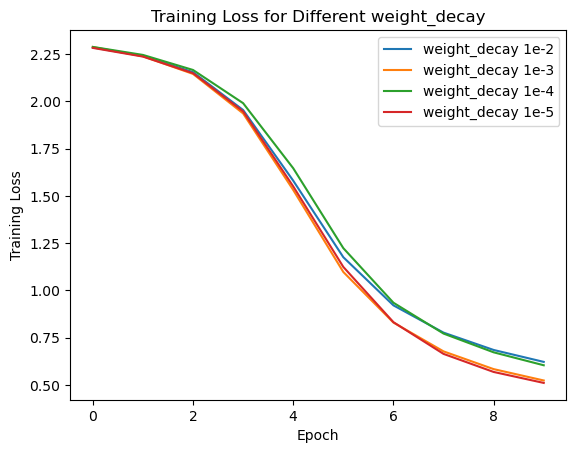

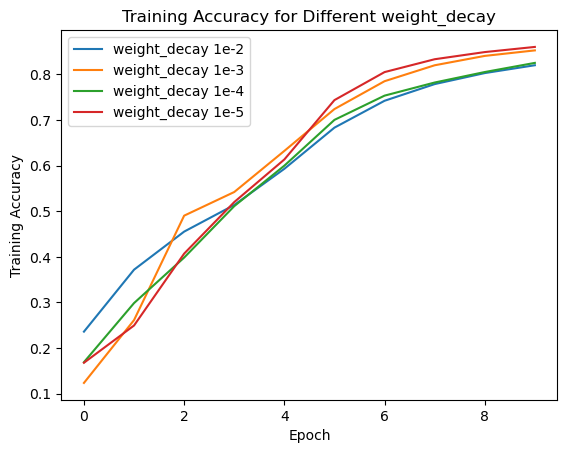

weight_decay  Test Accuracy
        1e-2         0.8323
        1e-3         0.8603
        1e-4         0.8410
        1e-5         0.8720


In [280]:
# Plot the training losses for each loss function
for i, losses in enumerate(train_losses):
    plt.plot(losses, label=f'weight_decay 1e{-i-2}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different weight_decay')
plt.legend()
plt.show()

# Plot the training accuracies for each loss function
for i, accs in enumerate(train_accuracies):
    plt.plot(accs, label=f'weight_decay 1e{-i-2}')

plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy for Different weight_decay')
plt.legend()  
plt.show()

import pandas as pd


data = {
    'weight_decay': ['1e-2', '1e-3', '1e-4', '1e-5'],
    'Test Accuracy': [test_accuracies[0], test_accuracies[1], test_accuracies[2], test_accuracies[3]]
}

# 创建一个DataFrame
df = pd.DataFrame(data)

# 显示表格
print(df.to_string(index=False))

### 4.1 使用SGD随机梯度下降，修改L2正则化参数

In [281]:
# loss_cross = nn.CrossEntropyLoss()
# # 将正则化参数从0.001改为0.01
# optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=0.01,lr=1e-3)
# net = FNN().to(device)

# SGD_train_losses, SGD_train_accuracies, SGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

In [282]:
class FNN_NLL(nn.Module):
    def __init__(self):
        super(FNN_NLL, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(400, 200), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200, 100), nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(100, 10), nn.LogSoftmax(dim=1))  # Apply log softmax to the output

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        output = self.layer4(x)
        return output
    
class FNN_HINGE(nn.Module):
    def __init__(self):
        super(FNN_HINGE, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(400, 200), nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(200, 100), nn.ReLU())
        self.layer4 = nn.Linear(100, 10)  # 假设有10个类别

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        output = self.layer4(x)
        return output

### 使用不同的损失函数并查看结果

In [ ]:
import matplotlib.pyplot as plt

# Define the loss functions
loss_functions = [nn.MultiMarginLoss() , nn.NLLLoss(), nn.CrossEntropyLoss()]
net0=FNN_HINGE().to(device)
net1= FNN_NLL().to(device)
net2 = FNN().to(device)
nets = [net0, net1, net2]
cnt = 0

# Create empty lists to store the results
train_losses = []
train_accuracies = []
test_accuracies = []

# Train the model with different loss functions
for loss_func in loss_functions:
    net = nets[cnt]
    cnt += 1
    # Create a new optimizer for each loss function
    optimizer = torch.optim.SGD(net.parameters(), weight_decay=1e-3, lr=1e-3)

    # Train the model and get the results
    losses, accuracies, test_accuracy = train_model(net, train_data, test_data, loss_func, optimizer, num_epochs=10)

    # Append the results to the lists
    train_losses.append(losses)
    train_accuracies.append(accuracies)
    test_accuracies.append(test_accuracy)

# Plot the training losses for each loss function
for i, losses in enumerate(train_losses):
    plt.plot(losses, label=f'Loss Function {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Loss Functions')
plt.legend()
plt.show()

# Plot the test accuracies for each loss function

plt.bar(range(len(loss_functions)), test_accuracies)
plt.xticks(range(len(loss_functions)), [f'Loss Function {i+1}' for i in range(len(loss_functions))])
plt.xlabel('Loss Function')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Loss Functions')
plt.show()
# SGD_train_losses, SGD_train_accuracies, SGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

In [ ]:
import pandas as pd


data = {
    'Loss Function': ['MultiMarginLoss', 'NLLLoss', 'CrossEntropyLoss'],
    'Test Accuracy': [test_accuracies[0], test_accuracies[1], test_accuracies[2]]
}

# 创建一个DataFrame
df = pd.DataFrame(data)

# 显示表格
print(df.to_string(index=False))

   Loss Function  Test Accuracy
 MultiMarginLoss         0.7911
         NLLLoss         0.8629
CrossEntropyLoss         0.8627


### 4.2 使用batch GD优化方式

In [ ]:
# import torch.nn as nn
# import torch.optim as optim

# train_data = DataLoader(train_set, batch_size=len(train_data),shuffle=True)

# net = FNN().to(device)

# loss_func = nn.CrossEntropyLoss()
# optimizer_batchgd = optim.SGD(net.parameters(),weight_decay=1e-3, lr=0.001)

# batchGD_train_losses, batchGD_train_accuracies, batchGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=10)

### 4.3 使用online GD优化方式

In [ ]:
# # online GD可以理解为带mini-bach的SGD，batch_size=1
# train_data = DataLoader(train_set, batch_size=1,shuffle=True)

# net = FNN().to(device)

# loss_func = nn.CrossEntropyLoss()
# optimizer_onlinegd = optim.SGD(net.parameters(), weight_decay=1e-3, lr=0.001)

# onlineGD_train_losses, onlineGD_train_accuracies, onlineGD_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_onlinegd, num_epochs=10)

### 4.4 使用mini-batch GD优化方式

In [ ]:
# train_data = DataLoader(train_set, batch_size=128,shuffle=True)
# net = FNN().to(device)
# loss_func = nn.CrossEntropyLoss()
# optimizer_minibatchgd = optim.SGD(net.parameters(),weight_decay=1e-3, lr=0.001)

# minibatchGD_train_losses, minibatchGD_train_accuracies, minibatchGD_test_accuracies = train_model(net,train_data,test_data,loss_cross,optimizer_minibatchgd,num_epochs=10)

### 4.5 使用adam优化方式

In [ ]:
# import torch.nn as nn
# from torch.optim import Adam
# train_data = DataLoader(train_set, batch_size=64,shuffle=True)
# net = FNN().to(device)
# # 定义损失函数
# loss_func = nn.CrossEntropyLoss()

# # 使用Adam优化器
# optimizer = Adam(net.parameters(), lr=0.001)

# # 定义训练的epoch数量
# num_epochs = 10

# # 调用之前定义的训练函数
# adam_train_losses, adam_train_accuracies, adam_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer, num_epochs)

### 4.6 使用Momentum优化算法

In [ ]:
# import torch.nn as nn
# from torch.optim import SGD

# net = FNN().to(device)
# loss_func = nn.CrossEntropyLoss()

# # Use Momentum optimizer
# optimizer_momentum = SGD(net.parameters(), lr=0.001, momentum=0.9)

# # Define the number of epochs
# num_epochs = 10

# # Call the train_model function with the Momentum optimizer
# momentum_train_losses, momentum_train_accuracies, momentum_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_momentum, num_epochs)

### 4.7 使用Adsgrad优化算法

In [ ]:
# # 使用adsgrad优化算法
# net = FNN().to(device)
# loss_func = nn.CrossEntropyLoss()

# optimizer_adagrad = torch.optim.Adagrad(net.parameters(), lr=0.001)

# num_epochs = 10

# adagrad_train_losses, adagrad_train_accuracies, adagrad_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer_adagrad, num_epochs)


### 4.8 使用Admax优化算法

In [ ]:
# from torch.optim import Adamax
# net = FNN().to(device)
# loss_func = nn.CrossEntropyLoss()

# # 使用Adamax优化器
# optimizer = Adamax(net.parameters(), lr=0.001)

# num_epochs = 10

# adamax_train_losses, adamax_train_accuracies, adamax_test_accuracies = train_model(net, train_data, test_data, loss_func, optimizer, num_epochs)


## 5 绘制不同optimizer的loss, accuracies图像和测试集的正确率

In [ ]:
# import matplotlib.pyplot as plt

# # Define the x-axis values (epochs)
# epochs = range(1, len(SGD_train_losses) + 1)

# # Plot the training loss for each algorithm
# plt.plot(epochs, losses_sgd, label='SGD, weight_decay=1e-3, batch_size=64')
# plt.plot(epochs, SGD_train_losses, label='SGD with weight decay=0.01')
# plt.plot(epochs, batchGD_train_losses, label='Batch GD, batch_size=len(train_data)')
# plt.plot(epochs, onlineGD_train_losses, label='Online GD, batch_size=1')
# plt.plot(epochs, minibatchGD_train_losses, label='Mini-batch GD, batch_size=128')
# plt.plot(epochs, adam_train_losses, label='Adam')
# plt.plot(epochs, momentum_train_losses, label='Momentum')
# plt.plot(epochs, adagrad_train_losses, label='Adagrad')
# plt.plot(epochs, adamax_train_losses, label='Adamax')

# # Add labels and title
# plt.xlabel('Epochs')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for Different Optimization Algorithms')

# # Show the legend
# # 图例移到右边
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# # Display the plot
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Define the optimizer names and test accuracies
# optimizers = ['SGD', 'Batch GD', 'Online GD', 'Mini-batch GD', 'Adam', 'Momentum', 'Adagrad', 'Adamax']
# test_accuracies = [test_ac_sgd, batchGD_test_accuracies, onlineGD_test_accuracies, minibatchGD_test_accuracies, adam_test_accuracies, momentum_test_accuracies, adagrad_test_accuracies, adamax_test_accuracies]

# # Plot the bar graph
# # 柱状图每个之间的距离开一些
# plt.figure(figsize=(10, 6))
# plt.bar(optimizers, test_accuracies)

# # Add labels and title
# plt.xlabel('Optimizer')
# plt.ylabel('Test Set Accuracy')
# plt.title('Test Set Accuracy for Different Optimizers')

# # Display the plot
# plt.show()

## 6 增加epoch并查看图像

In [ ]:
# import numpy as np

# epochs = [10, 20, 30, 50, 100]

# for epoch in epochs:
#     loss_cross = nn.CrossEntropyLoss()
#     net = FNN().to(device)
#     optimizer = torch.optim.SGD(net.parameters(),weight_decay=0, lr=1e-3)
#     losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer,num_epochs=epoch)
#     # Plot the training loss for each algorithm
#     epochs_x = np.arange(1, epoch + 1)
#     plt.plot(epochs_x, losses_sgd, label=f'epochs={epoch}')
#     # Add labels and title
#     plt.xlabel('Epochs')
#     plt.ylabel('Training Loss')
#     plt.title('Training Loss for Different Times Of Epochs In SGD Algorithm')

# # Show the legend
# plt.legend()

# # Display the plot
# plt.show()


## 7 更改网络结构并查看有什么影响

In [ ]:
from torch import nn

class my_FNN(nn.Module):
    def __init__(self):
        super(my_FNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784,400),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(400,150),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(150,10))

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        output = self.layer3(x)
        return output
    
class my_FNN2(nn.Module):
    def __init__(self):
        super(my_FNN2,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(784,600),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(600,400),nn.ReLU())
        self.layer3 = nn.Sequential(nn.Linear(400,200),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Linear(200,100),nn.ReLU())
        self.layer5 = nn.Sequential(nn.Linear(100,10))

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        output = self.layer5(x)
        return output
    

net = FNN().to(device)
loss_cross = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(net.parameters(),weight_decay=1e-3,lr=1e-3)
losses_sgd, accs_sgd, test_ac_sgd = train_model(net,train_data,test_data,loss_cross,optimizer_sgd,num_epochs=20)

my_net = my_FNN().to(device)
loss_cross = nn.CrossEntropyLoss()
my_optimizer_sgd = torch.optim.SGD(my_net.parameters(),weight_decay=1e-3,lr=1e-3)
my_losses_sgd, my_accs_sgd, my_test_ac_sgd = train_model(my_net,train_data,test_data,loss_cross,my_optimizer_sgd,num_epochs=20)

my_net2 = my_FNN2().to(device)
loss_cross = nn.CrossEntropyLoss()
my_optimizer_sgd2 = torch.optim.SGD(my_net2.parameters(),weight_decay=1e-3,lr=1e-3)
my_losses_sgd2, my_accs_sgd2, my_test_ac_sgd2 = train_model(my_net2,train_data,test_data,loss_cross,my_optimizer_sgd2,num_epochs=20)

import matplotlib.pyplot as plt

# Define the x-axis values (epochs)
epochs = range(1, len(losses_sgd) + 1)
plt.plot(epochs, losses_sgd, label='The original 4 layers model with SGD')
plt.plot(epochs, my_losses_sgd, label='3 layers FNN model with SGD')
plt.plot(epochs, my_losses_sgd2, label='5 layers FNN model with SGD')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Networks')

plt.legend()

# Display the plot
plt.show()



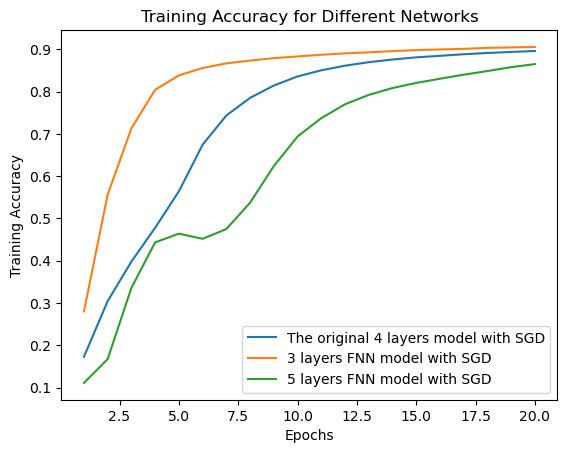

     FNN  Test Accuracy
3 layers         0.9097
4 layers         0.9013
5 layers         0.8690


In [ ]:

# Define the x-axis values (epochs)
epochs = range(1, len(accs_sgd) + 1)
plt.plot(epochs, accs_sgd, label='The original 4 layers model with SGD')
plt.plot(epochs, my_accs_sgd, label='3 layers FNN model with SGD')
plt.plot(epochs, my_accs_sgd2, label='5 layers FNN model with SGD')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy for Different Networks')

plt.legend()

# Display the plot
plt.show()

import pandas as pd
# 可视化三种FNN的test_accuracy
# 创建一个新的图形
data = {
    'FNN': ['3 layers', '4 layers', '5 layers'],
    'Test Accuracy': [my_test_ac_sgd, test_ac_sgd, my_test_ac_sgd2]
}

# 创建一个DataFrame
df = pd.DataFrame(data)

# 显示表格
print(df.to_string(index=False))


## 5 测试集上的准确率

同学们将测试过程补充在这里

In [ ]:
# eval_loss = 0
# eval_acc = 0
# net.eval() 	# 将模型改为预测模式,不启用 BatchNormalization 和 Dropout

# for image, label in test_data:
#     image = image.view(image.size(0), -1)

#     # 进行测试
#     '''
#     步骤：
#     1. 前向传播计算loss
#     2. 计算测试集上的总eval_loss
#     3. 得到预测结果
#     4. 计算预测正确的图片数量
#     5. 得到elva_acc准确率
#     '''
    
    
    
    

# print('Eval Loss: {:.6f}, Eval Acc: {:.6f}'.format(eval_loss/len(test_data), eval_acc/len(test_data)))